# Modelo de Segmentacion: conjunto de viviendas precarias.

Este notebook hace...

### Paso 0 : importe de librerias y configuraciond el entrono

In [1]:
import gdown
import glob
import utils
import random
import numpy as np
import torch
import os
import subprocess
import rastervision
import rasterio
from subprocess import check_output
from aux_functions import download_blob_from_azure

from rastervision.core.data import RasterioSource, MinMaxTransformer

from rastervision.core.data import (
    ClassConfig, GeoJSONVectorSource, RasterioCRSTransformer,
    RasterizedSource, ClassInferenceTransformer)

from rastervision.core.data import SemanticSegmentationLabelSource

from rastervision.core.data.utils.geojson import get_polygons_from_uris
from shapely.geometry import Polygon

from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset, SemanticSegmentationSlidingWindowGeoDataset, SemanticSegmentationVisualizer)

import albumentations as A

import torch
from torch.utils.data import ConcatDataset

from rastervision.pytorch_learner import SemanticSegmentationGeoDataConfig
from rastervision.pytorch_learner import SolverConfig
from rastervision.pytorch_learner import SemanticSegmentationLearnerConfig
from rastervision.pytorch_learner import SemanticSegmentationLearner


c:\Users\oltie\anaconda3\envs\ssmodel_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\oltie\anaconda3\envs\ssmodel_env\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


configura las variables de entorno necesarias para trabajar con las bibliotecas geoespaciales. Ajusta la variable GDAL_DATA utilizando la ubicación de rasterio, y establece AWS_NO_SIGN_REQUEST para evitar problemas de autenticación al acceder a datos en AWS.

In [2]:
import torch
if torch.cuda.is_available():
    print("PyTorch version:", torch.__version__)
    print("Is CUDA available:", torch.cuda.is_available())
    print("CUDA version:", torch.version.cuda)
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device found")
    # Optionally, check where a tensor is located
    x = torch.randn(3, 3)
    print(f"device viejo: {x.device}")  # should print 'cpu' if on CPU

    # To move a tensor or model to the GPU
    x = x.cuda()
    print(f"device nuevo: {x.device}")  # should print 'cuda:0' if on GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    print("no tiene CUDA Disponible, no puedes seguir con el mdoelo")

PyTorch version: 2.5.0+cu124
Is CUDA available: True
CUDA version: 12.4
Number of GPUs: 1
Current device: 0
Device name: NVIDIA GeForce RTX 3060 Laptop GPU
device viejo: cpu
device nuevo: cuda:0


In [3]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [4]:

# os.environ['GDAL_DATA'] = check_output('pip show rasterio | grep Location | awk \'{print $NF"/rasterio/gdal_data/"}\'', shell=True).decode().strip()
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'


# Get the location of rasterio
rasterio_location = check_output('pip show rasterio', shell=True).decode()

# Find the line that specifies the location
gdal_data_path = None
for line in rasterio_location.splitlines():
    if line.startswith("Location:"):
        gdal_data_path = os.path.join(line.split(":", 1)[1].strip(), 'rasterio', 'gdal_data')
        break

# Set the GDAL_DATA environment variable if we found the path
if gdal_data_path:
    os.environ['GDAL_DATA'] = gdal_data_path
    print(f"GDAL_DATA has been set to: {gdal_data_path}")
else:
    print("Could not find the GDAL data path.")


GDAL_DATA has been set to: C:\Users\oltie\anaconda3\envs\ssmodel_env\Lib\site-packages\rasterio\gdal_data


Configurar la Semilla Global y cuDNN

In [5]:


# Set global seed for reproducibility
def set_global_seed(seed):
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # NumPy's random module
    torch.manual_seed(seed)  # PyTorch seed for CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # PyTorch seed for current GPU
        torch.cuda.manual_seed_all(seed)  # PyTorch seed for all GPUs (if using multi-GPU)

# Prepare cuDNN for deterministic behavior
def prepare_cudnn(deterministic=True):
    torch.backends.cudnn.deterministic = deterministic  # cuDNN deterministic setting
    torch.backends.cudnn.benchmark = not deterministic  # Disable cuDNN benchmarking if deterministic

# Set the seed and configure cuDNN
SEED = 42
set_global_seed(SEED)
prepare_cudnn(deterministic=True)


### Paso 1: Descargar la Data

(separamos en train y val por si en el futuro se usan imagenes diferentes...) 

(tambien peuden ser mas de una imagen, solo tienen que ser guardadas en un alistas con sus uris ej: ['./data/train/img1','/data/train/img2'])

Antes de continuar, una **aclaración importante**: para que sean compatibles con las funciones de `rastervision`, todos los archivos con polígonos georreferenciados -anotaciones y área de interés- deben tener proyección geográfica WGS 84. también conocida como EPSG:4326.

#### empezamos con las imagenes:

explicar de donde sacamos las imagenes

In [6]:
#imagenes
# Imágenes

download_blob_from_azure('train_GoogleE_z19.tif', './data/train/img/')
train_img_uri = './data/train/img/train_GoogleE_z19.tif'

download_blob_from_azure('2023.tif', './data/val/img/')
val_img_uri = './data/val/img/val_GoogleE_z19.tif'


#### Seguimos con las anotacions (labels):

explicar de donde las sacamos etc.

In [7]:
# Labels

# download_blob_from_azure('2023_viviendas.geojson','./data/train/labels/')
train_labels_uri = './data/train/labels/2023_viviendas.geojson'

# download_blob_from_azure('2023_viviendas.geojson', './data/val/labels/')
val_labels_uri = './data/val/labels/2023_viviendas.geojson'


#### Y por ultimo las areas de interes (AoI) de cada uno. 
Las áreas de interés (AoI) se dividen en dos conjuntos: entrenamiento (train) y validación (val). El conjunto de entrenamiento incluye cinco barrios, mientras que el de validación incluye dos barrios. Esta división se hizo para reducir el tiempo de cómputo. Modificando el archivo .geojson correspondiente, se puede ajustar qué áreas se asignan a cada conjunto.

Áreas de Entrenamiento (train):
- Morón
- Tres de Febrero
- La Matanza
- Merlo
- San Miguel

Áreas de Validación (val):
- Moreno
- José C. Paz


In [8]:
# download_blob_from_azure('train_aoi.geojson', './data/train/')
# download_blob_from_azure('val_aoi.geojson', './data/val/')

train_AoI_uri = './data/train/train_aoi.geojson'
val_AoI_uri = './data/val/val_aoi.geojson'

### Paso 2: Preprocesamiento: extracción de recortes para entrenamiento y test

Ahora hay que enfrentar el problema de como analizar una imagen quizás inmensa (de varios gigas de tamaño, en ocasiones), teniendo en cuenta que la memoria disponible en la GPU es limitada.

La solución es dividir la imagen aérea en una colección de recortes cuadrados (o "ventanas"), de mucho menor tamaño, para ser analizados uno a uno y permiter que el algoritmo aprenda a reconocer patrones que coinciden coon la presencia de basura de acuerdo a las anotaciones. Esta es una de las tareas donde nos ayudan las funciones de la librería [rastervision](https://rastervision.io/).

El tamaño de las ventanas es importante, por que afectan la performance de entrenamiento del modelo, pero no hay una receta exacta para definirlo. En general, cuanta mayor resolución presentan las imágenes a analizar, más nos vamos a beneficiar de usar ventanas grandes.

* Para imágenes satelitales de acceso público con resolucioń moderada, como las del [proyecto Sentinel](https://apps.sentinel-hub.com/eo-browser/) (10 metros por pixel), podemos usar recortes de 128 x 128 píxeles.
* Para imágenes de satélites comerciales, o fotos aéres tomadas a gran altura, podemos usar 256 x 256.
* Y para imágenes de altísima resolución, como estas de 3 cm/pixel, probar con 480 x 480 píxeles como haremos a continuación.

Como paso adicional de preprocesamiento, es una práctica común realizar una serie de distorsiones sobre los recortes de la imagen antes de pasarlos al algoritmo durante la fase de entrenamiento: al azar cambiarles el brillo, la saturación, borrar algunos de los píxeles, etc. A estos ajustes se les llama __"augmentations"__.

Aunque parezca destructivo, es comprobable que esto mejora la performance del algoritmo. Lo hace más robusto a la hora de aplicarlo para detectar objetos en otras imágenes, que no se han usado para su entrenamiento, y que siempre presentarán diferencias -por menores que sean- en saturación, brillo, pixeles faltantes, etc.

Con el siguiente código definimos importantes parámetros: la clase de objeto a detectar, el tamaño de los recortes de imagen a procesar, y las _augmentations_ con las que torturaremos a esos recortes:

In [9]:
# Aquí definimos las clases (tipos de objeto) presentes en nuestras anotaciones
# en este caso tenemos sólo una, que indicamos como "viviendas precarias" .
# hay un clase adicional, implícita, que es "background" -el fondo, todo lo que
# no corresponde a objetos de intéres

class_config = ClassConfig(
    names=['background', 'viviendas precarias'],
    colors=['lightgray', 'darkred'],
    null_class='background')


# el tamaño en píxeles de los recortes cuadrados
window_size = 512

# Aquí definimos algunas transformaciones a realizar a los recorte del dataset
# de entrenamiento: cambiar al azar la saturación, el brillo, rotarlos, ocultar
# algunos pixeles. Todo esto sirve para entrenar un algoritmo de detección
# más robusto a diferencias que puedan tener las futuras imágenes a las que
# se aplique
data_augmentation_transform = A.Compose([
    A.Flip(),
    A.ShiftScaleRotate(),
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=10),
        A.RandomBrightnessContrast(),
        A.RandomGamma(),
        A.RGBShift(),
        # A.ToGray(),
        # A.ToSepia(),
    ]),
    A.CoarseDropout(max_height=int(window_size/6), max_width=int(window_size/6), max_holes=4)
])


Como es típico en aplicaciones de machine learning, vamos a separar nuestras datos en dos conjuntos, o "datasets": Un dataset de imágenes **de entrenamiento** que se van a usar para que el algoritmo aprenda, y otro dataset **de validación**  que se va a utilizar para medir su performance.

#### creamos los datasets de entrenamiento (train) y de validacion (val)

El dataset de validación se utiliza para medir la performance de detección: Tras cada iteración en la cual el algoritmo ha procesado ejemplos de basurales para "aprender" los rasgos visuales que se asociana su presencia, evaluamos la performance lograda haciendo que recorra cada punto del área de trabajo, registrando si identifica cada instancia conocida.

Para el dataset de entrenamiento, el que algoritmo va a procesar, comparando con las anotaciones para descubrir que patrones corresponden a la presencia de basurales, queremos un muestreo al azar en lugar de un mosaico de ventanas contiguas.

Aunque no sea muy intuitivo en principio, el muestreo al azar con ventanas que se solapan produce mejores resultados que entrenar al algoritmo con imágenes en una grilla regular en las que ningun pixel se repite entre recortes.

Un muestreo al azar luciría así:

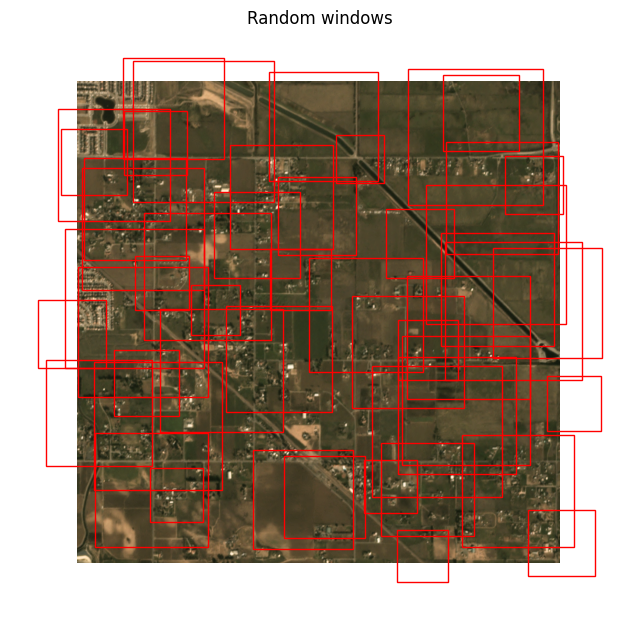

In [10]:
def create_val_ds(image_uris, class_config, AoI_file_dest_uri, val_labels_uri, window_size):
    datasets = []
    
    # Ensure image_uris is a list, even if there is only one image
    if not isinstance(image_uris, list):
        image_uris = [image_uris]

    for image_uri in image_uris:
        val_ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
            class_config=class_config,
            aoi_uri=AoI_file_dest_uri,
            image_uri=image_uri,
            label_vector_uri=val_labels_uri,
            label_vector_default_class_id=class_config.get_class_id('viviendas precarias'),
            image_raster_source_kw=dict(allow_streaming=True, raster_transformers=[MinMaxTransformer()]),
            size=window_size,
            stride=window_size,
            transform=A.Resize(window_size, window_size)
        )
        datasets.append(val_ds)

    # Concatenate all datasets if any exist, otherwise return None
    combined_val_ds = sum(datasets[1:], datasets[0]) if datasets else None
    
    return combined_val_ds


In [11]:
# Crear el dataset de validación
val_ds = create_val_ds(
    image_uris=val_img_uri,
    class_config=class_config,
    AoI_file_dest_uri=val_AoI_uri,
    val_labels_uri=val_labels_uri,
    window_size=window_size
)

len(val_ds)


3531

vemos si se estan bien los recortes de val

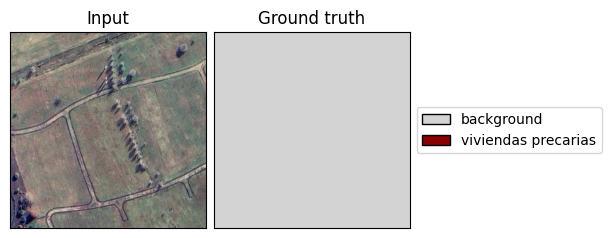

In [12]:
vis = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors)

x, y = val_ds[10]

vis.plot_batch(x.unsqueeze(0), y.unsqueeze(0), show=True)

In [13]:
def create_train_ds(image_uris, class_config, AoI_file_dest_uri, train_labels_uri, window_size, sample_size, data_augmentation_transform):
    datasets = []
    
    # Ensure image_uris is a list, even if there is only one image
    if not isinstance(image_uris, list):
        image_uris = [image_uris]

    for image_uri in image_uris:
        train_ds = SemanticSegmentationRandomWindowGeoDataset.from_uris(
            class_config=class_config,
            aoi_uri=AoI_file_dest_uri,
            image_uri=image_uri,
            label_vector_uri=train_labels_uri,
            label_vector_default_class_id=class_config.get_class_id('viviendas precarias'),
            image_raster_source_kw=dict(allow_streaming=True, raster_transformers=[MinMaxTransformer()]),
            size_lims=(window_size, window_size + 1),
            out_size=window_size,
            padding=100,  # Adjust the padding as needed
            max_windows=sample_size,
            transform=data_augmentation_transform
        )
        datasets.append(train_ds)
    
    # Concatenate all datasets if any exist, otherwise return None
    combined_train_ds = sum(datasets[1:], datasets[0]) if datasets else None
    
    return combined_train_ds

In [14]:
# Open the image to get its dimensions
with rasterio.open(train_img_uri) as src:
    width = src.width
    height = src.height

# Calculate the size divided by window_size
size_divided_by_window = (width // window_size, height // window_size)
print(f"Size of train_img_uri / window_size = {size_divided_by_window}")
num_windows = size_divided_by_window[0] * size_divided_by_window[1]
print(f"Number of 512x512 windows that fit in train_img_uri: {num_windows}")

Size of train_img_uri / window_size = (146, 181)
Number of 512x512 windows that fit in train_img_uri: 26426


In [15]:
# Crear el dataset de entrenamiento
train_ds = create_train_ds(
    image_uris=train_img_uri,
    class_config=class_config,
    AoI_file_dest_uri=train_AoI_uri,
    train_labels_uri=train_labels_uri,
    window_size=window_size,
    sample_size= len(val_ds)*10, #como las area de val es mas chica me aseguro de que train tenga 10 veces mas de imagenes para cubrir mejor el area con random windows.
    data_augmentation_transform=data_augmentation_transform
)

len(train_ds)


35310

es necesario pasar los valores a long ya que es lo que pytorch necesita para poder leer bien los pixeles de las imagenes al usar rastervision. (patch code)

In [16]:
from torch.utils.data import Dataset

class LongTargetDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        x, y = self.base_dataset[idx]
        y = y.long()  # Ensure target is LongTensor
        return x, y

In [17]:
# Wrap train and validation datasets
train_ds = LongTargetDataset(train_ds)
val_ds = LongTargetDataset(val_ds)

Elijamos unos cuantos de estos recortes al azar, a ver como quedan: (para notar que realmente son al azar, ejecuten el código varias veces para obtener resultados distintos)

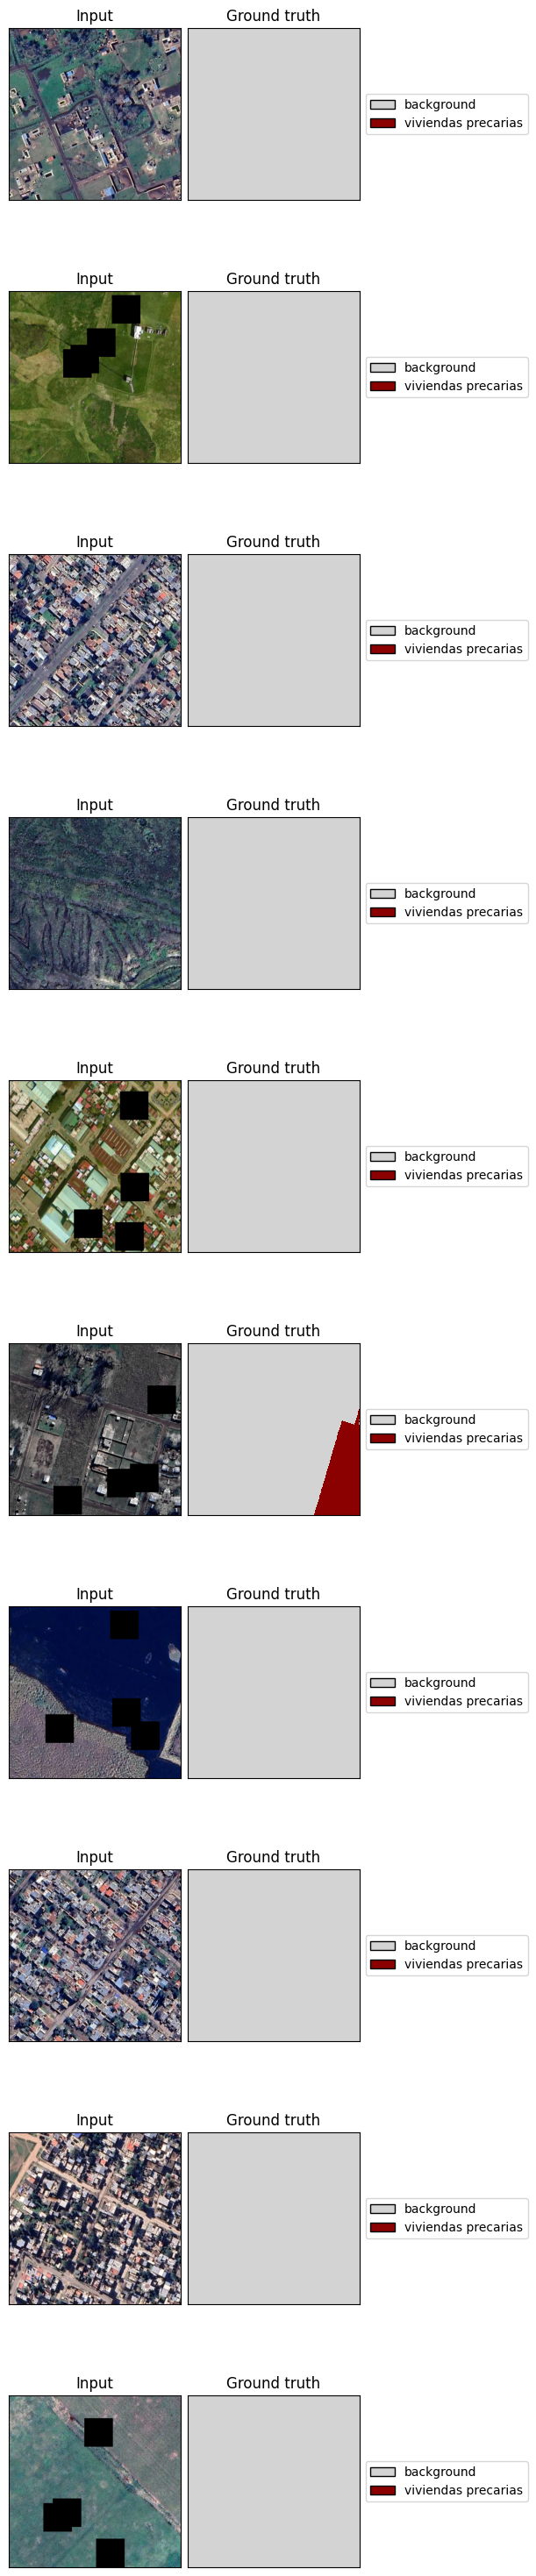

In [18]:
x, y = vis.get_batch(train_ds, 10)

vis.plot_batch(x, y, show=True)

### Paso 3: Entrenando un modelo de clasificación de imagen


En lugar de partir de cero, tomaremos como base un modelo de uso general llamado _RESNET18_, una red neuronal de uso general que puede re-entrenarse para ser especializada en cualquier clase específica de objetos de interés. 

_*Modelo*_ --> Use model a light-weight panoptic FPN model with a ResNet-18 backbone. (extract from https://github.com/AdeelH/pytorch-fpn)

Definimos el modelo base con el que vamos a trabajar:

possible resnet to use
            "resnet18",
            "resnet34",
            "resnet50",
            "resnet101",
            "resnet152",
            "resnext50_32x4d",
            "resnext101_32x8d",

In [19]:
import torch

model = torch.hub.load(
    'AdeelH/pytorch-fpn:0.3',
    'make_fpn_resnet',
    name='resnet18',
    fpn_type='panoptic',
    num_classes=len(class_config),
    fpn_channels=128,
    in_channels=3,
    out_size=(window_size, window_size),
    pretrained=True).to(device)


Using cache found in C:\Users\oltie/.cache\torch\hub\AdeelH_pytorch-fpn_0.3


Ahora configuramos las opciones para el entrenamiento, entre ellas:

* Cuántas iteraciones (la cantidad de veces que se volverán a recorrer los datos, buscando mejorar la predicción en base a lo aprendido en el ciclo anterior). Cuantas más, mejor para buscar mejores resultados -pero una cantidad grande de iteraciones puede tomar muchas, muchas horas.

* Cuántas imágenes analizar al mismo tiempo, en tandas (cuantas más mejor, pero el límite lo fija la cantidad de memoria GPU RAM)

* En que archivo guardar el modelo con sus parámetros actualizados, tras cada iteracion

* Cuáles son los datasets de entenamiento y de validación que utilizará para encontrar los mejores resultados. Estos son los que definimos en el paso anterior.



In [26]:
# Set the number of epochs and the directory to save the model
n_epochs = 2
model_folder = f"./data/models/bundle_google_{n_epochs}/"

# Define the batch size for training
batch_images = 6

# Configure the dataset with the class information
data_cfg = SemanticSegmentationGeoDataConfig(
    class_config=class_config,
    num_workers=0  # Set to 0 for Google Colab, to avoid multiprocessing issues
)

# Configure the solver (optimizer and scheduler)
solver_cfg = SolverConfig(
    batch_sz=batch_images,
    lr=3e-2,
    num_epochs=n_epochs,  # Specify number of epochs in the solver config
    class_loss_weights=[1.0, 10.0]  # Lower weight for background, higher for houses (nn.CrossEntropyLoss)
)

# Build the optimizer and scheduler from solver configuration
optimizer = solver_cfg.build_optimizer(model)
scheduler = solver_cfg.build_epoch_scheduler(optimizer)

# Combine everything into the learner configuration
learner_cfg = SemanticSegmentationLearnerConfig(
    data=data_cfg,
    solver=solver_cfg
)

# Instantiate the learner with the built optimizer and scheduler
learner = SemanticSegmentationLearner(
    cfg=learner_cfg,
    output_dir=model_folder,
    model=model,
    train_ds=train_ds,
    valid_ds=val_ds,
    training=True
)

# Now manually set the optimizer and scheduler into the learner if needed
learner.optimizer = optimizer
learner.scheduler = scheduler


2024-10-22 23:43:18:rastervision.pytorch_learner.learner: INFO - Building dataloaders


Visualizamos el progreso gracias a tensorboard. Nos sirve para ver la performance en grraficos con todas las metricas. (f1, recall, presicion)

In [27]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [28]:
logdir = f"./data/models/bundle_google_{n_epochs}/tb-logs"
%tensorboard --bind_all --logdir $logdir --reload_interval 10

Reusing TensorBoard on port 6007 (pid 24252), started 0:47:40 ago. (Use '!kill 24252' to kill it.)

*Y* con todo definido, finalmente... ¡a entrenar!:

In [29]:
torch.cuda.empty_cache()

In [30]:
# Inicia el entrenamiento
learner.train(epochs=n_epochs)

2024-10-22 23:43:23:rastervision.pytorch_learner.learner: INFO - train_ds: 35310 items
2024-10-22 23:43:23:rastervision.pytorch_learner.learner: INFO - valid_ds: 3531 items
2024-10-22 23:43:23:rastervision.pytorch_learner.learner: INFO - Plotting sample training batch.
2024-10-22 23:43:26:rastervision.pytorch_learner.learner: INFO - Plotting sample validation batch.
2024-10-22 23:43:28:rastervision.pytorch_learner.learner: INFO - epoch: 0
Validating: 100%|██████████| 589/589 [17:48<00:00,  1.81s/it]
2024-10-23 04:32:40:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 0,
 'train_loss': 0.5589180588722229,
 'train_time': '4:31:24.412408',
 'val_loss': 0.5980904698371887,
 'avg_precision': 0.8288777470588684,
 'avg_recall': 0.9028568863868713,
 'avg_f1': 0.8642871975898743,
 'background_precision': 0.9028652310371399,
 'background_recall': 0.9999895691871643,
 'background_f1': 0.9489487409591675,
 'viviendas precarias_precision': 0.14116951823234558,
 'viviendas precarias_r

visualizamos las predicciones:

2024-10-23 09:59:57:rastervision.pytorch_learner.learner: INFO - Making and plotting sample predictions on the valid set...


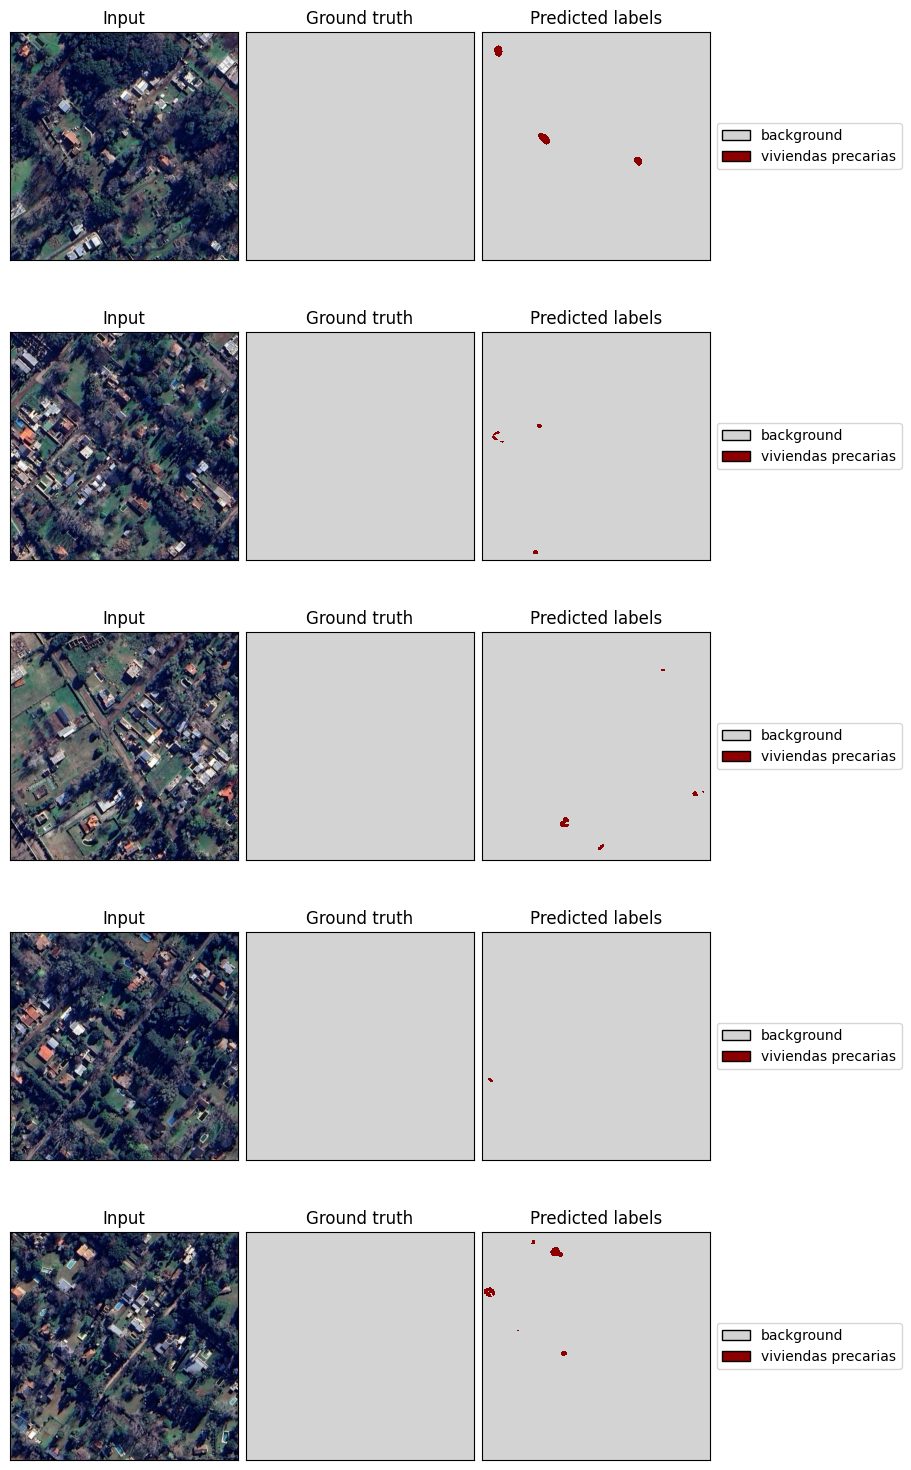

2024-10-23 10:00:00:rastervision.pytorch_learner.learner: INFO - Sample predictions written to ./data/models/bundle_google_2/valid_preds.png.


In [32]:
learner.plot_predictions(split='valid', show=True,batch_limit=5)

guardamos el modelo en un .zip. 

La función `save_model_bundle()` guarda un archivo con nombre "model-bundle.zip" en la carpeta que definimos antes, al momento de configurar el entrenamiento:

In [ ]:
learner.save_model_bundle()

LO DE ABAJO ESTA INCOPLETO Y NO SE USO TODAVIA


### Paso 4 (opcional): fine-tunning de un modelo ya usado.

agarrar el mdoelo utilizado anteriormente y entrenarlo con nuevas imagenes.

In [44]:
fine_tuning = False

In [ ]:
if fine_tuning:
    #BSUCAR NUEVA DATA Y HACER LOS DATASETS
    from rastervision.pytorch_learner import SemanticSegmentationLearner

    learner = SemanticSegmentationLearner.from_model_bundle(
        model_bundle_uri=f'data/models/bundle_{n_epochs}/model-bundle.zip',
        output_dir=f'data/models/bundle_{n_epochs}_extra/',
        model=model,
        train_ds=train_ds_nueva,
        valid_ds=val_ds_nueva,
        training=True,
    )
    # Inicia el entrenamiento
    learner.train(epochs=n_epochs)

# ____________________________________________________________________________


# Predecir. 

In [1]:
import glob
from pathlib import Path

import gc

import os

import torch

from rastervision.core.data import ClassConfig
from rastervision.core.data import SemanticSegmentationLabels, SemanticSegmentationDiscreteLabels
from rastervision.core.data import RasterioSource, MinMaxTransformer
from rastervision.core.data.label_store.semantic_segmentation_label_store_config import PolygonVectorOutputConfig

from rastervision.pytorch_learner import SemanticSegmentationLearner
from rastervision.pytorch_learner import SolverConfig
from rastervision.pytorch_learner import SemanticSegmentationLearnerConfig
from rastervision.pytorch_learner import SemanticSegmentationSlidingWindowGeoDataset
from rastervision.pytorch_learner import SemanticSegmentationGeoDataConfig

from aux_functions import download_blob_from_azure

c:\Users\oltie\anaconda3\envs\ssmodel_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\oltie\anaconda3\envs\ssmodel_env\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# import gdown

# model_folder = "/content/drive/MyDrive/IA/basurales/modelo_pre_entrenado/"
model_folder = "./data/models/"
# !mkdir -p $model_folder
# model_url = "https://drive.google.com/file/d/1DdjZBPrMNsCp35tZSk7u-EgnIYe0wDu9/view?usp=sharing"
model_path = f"./data/models/bundle_google_{n_epochs}/model-bundle.zip"

# gdown.download(model_url, model_path, fuzzy=True)

NameError: name 'n_epochs' is not defined

In [ ]:
class_config = ClassConfig(
    names=['background', 'viviendas precarias'],
    colors=['lightgray', 'darkred'],
    null_class='background')
class_config.ensure_null_class()


window_size = 64

model = torch.hub.load(
    'AdeelH/pytorch-fpn:0.3',
    'make_fpn_resnet',
    name='resnet18',
    fpn_type='panoptic',
    num_classes=len(class_config),
    fpn_channels=128,
    in_channels=3,
    out_size=(window_size, window_size),
    pretrained=True)


learner = SemanticSegmentationLearner.from_model_bundle(model_bundle_uri=model_path, model=model, output_dir=model_folder, training=False)

Using cache found in C:\Users\oltie/.cache\torch\hub\AdeelH_pytorch-fpn_0.3
2024-10-09 11:24:56:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle ./data/models/bundle_100/model-bundle.zip.
2024-10-09 11:24:56:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to C:\Users\oltie\AppData\Local\Temp\tmpypc17zu1\model-bundle
2024-10-09 11:24:57:rastervision.pytorch_learner.learner: INFO - Loading model weights from: C:\Users\oltie\AppData\Local\Temp\tmpypc17zu1\model-bundle\model.pth


In [ ]:
# from aux_functions import combine_geojsons
# combine_geojsons('test', [
#     './data/aoi/lomas_de_zamora.geojson',
#     './data/aoi/quilmes.geojson'
# ], 'data/test')

In [ ]:
test_img_uri = "./data/test/img/"
test_img_name = "2023.tif"
test_labels_uri = "./data/test/labels/"
test_labels_name = "2023_viviendas.geojson"

download_blob_from_azure(test_img_name, test_img_uri)
test_img_uri = test_img_uri + test_img_name

download_blob_from_azure(test_labels_name, test_labels_uri)
test_labels_uri = test_labels_uri + test_labels_name

download_blob_from_azure('test_aoi.geojson', './data/test/')
test_Aoi_uri = "./data/test/test_aoi.geojson"


2023.tif: 100%|##########| 362M/362M [00:48<00:00, 7.52MB/s] 


Downloaded '2023.tif' to './data/test/img/2023.tif'


2023_viviendas.geojson: 100%|##########| 1.58M/1.58M [00:00<00:00, 6.34MB/s]


Downloaded '2023_viviendas.geojson' to './data/test/labels/2023_viviendas.geojson'


test_aoi.geojson: 100%|##########| 38.5k/38.5k [00:00<00:00, 224kB/s]

Downloaded 'test_aoi.geojson' to './data/test/test_aoi.geojson'


In [ ]:
window_size = 64
save_dir = f"./data/results/preds_{n_epochs}/"

img_raster_source = RasterioSource(test_images_uri, allow_streaming=True, raster_transformers=[MinMaxTransformer()])

pred_ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=test_images_uri,
    image_raster_source_kw=dict(allow_streaming=True),
    aoi_uri=test_Aoi_uri,
    size=window_size,
    stride=window_size)

predictions = learner.predict_dataset(
    pred_ds,
    raw_out=True,
    numpy_out=True,
    predict_kw=dict(out_shape=(window_size, window_size)),
    progress_bar=True)

pred_labels = SemanticSegmentationLabels.from_predictions(
    pred_ds.windows,
    predictions,
    smooth=True,
    extent=pred_ds.scene.extent,
    num_classes=len(class_config))

# # liberamos memoria
# del pred_ds
# gc.collect()

# Guardar predicciones
pred_labels.save(
    uri=save_dir,
    crs_transformer=img_raster_source.crs_transformer,
    class_config=class_config,
    # set to False to skip writing `labels.tif`
    discrete_output=False,
    # set to False to skip writing `scores.tif`
    smooth_output=False,
    # set to True to quantize floating point score values to uint8 in scores.tif to reduce file size
    smooth_as_uint8=True,
    # vector outputs are now always written to <pred root URI>/vector_outputs/class-<i>-<class name>.json
    vector_outputs=[PolygonVectorOutputConfig(class_id=1)]
)

# # renombramos el archivo con la predicción
# !mv {save_dir + "vector_output/class-1-basural.json"} {save_dir + "vector_output/" + Path(raster_file).stem + "_prediction.json"}

# # limpieza final
# del predictions
# del pred_labels
# gc.collect()

Predicting: 100%|██████████| 754/754 [00:06<00:00, 118.35it/s]
2024-10-09 11:25:06:rastervision.core.data.label_store.semantic_segmentation_label_store: INFO - Writing vector outputs to disk.
Vectorizing predictions: 100%|██████████| 1/1 [00:04<00:00,  4.91s/it, class_id=1, denoise=8, threshold=None, type_hint=polygon_vector_output]


In [ ]:
scores = pred_labels.get_score_arr(pred_labels.extent)

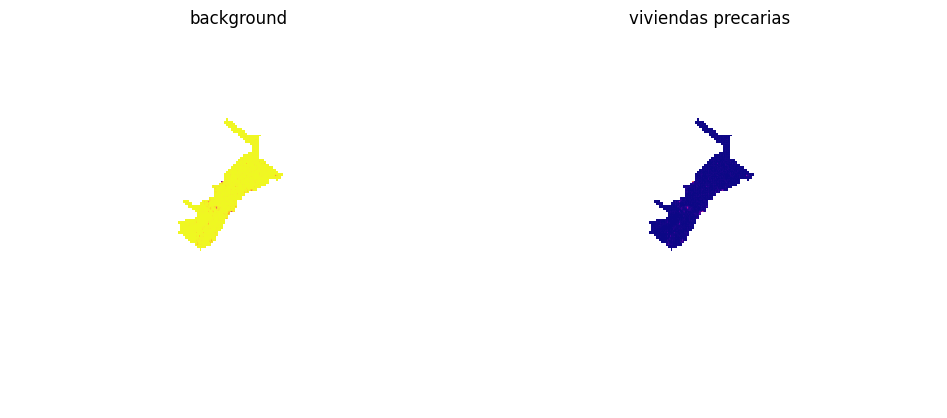

In [ ]:
from matplotlib import pyplot as plt

scores_vivienda = scores[1]
scores_background = scores[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(w_pad=-2)
ax1.imshow(scores_background, cmap='plasma')
ax1.axis('off')
ax1.set_title('background')
ax2.imshow(scores_vivienda, cmap='plasma')
ax2.axis('off')
ax2.set_title('viviendas precarias')
plt.show()

In [ ]:
pred_labels.save(
    uri=save_dir,
    crs_transformer=img_raster_source.crs_transformer,
    class_config=class_config,
    # discrete_output=False,
    # smooth_output=False,
    smooth_as_uint8=True,
    vector_outputs=[PolygonVectorOutputConfig(class_id=1)]
)

Saving pixel scores: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]
2024-10-09 11:25:35:rastervision.core.data.label_store.semantic_segmentation_label_store: INFO - Writing vector outputs to disk.
Vectorizing predictions: 100%|██████████| 1/1 [00:04<00:00,  4.52s/it, class_id=1, denoise=8, threshold=None, type_hint=polygon_vector_output]


In [ ]:
from rastervision.core.data.utils import make_ss_scene

scene = make_ss_scene(
    class_config=class_config,
    image_uri=test_images_uri,
    label_vector_uri=test_labels_uri,
    label_vector_default_class_id=class_config.get_class_id('viviendas precarias'),
    label_raster_source_kw=dict(
        background_class_id=class_config.get_class_id('background')),
    image_raster_source_kw=dict(allow_streaming=True))

gt_labels = scene.label_source.get_labels()

In [ ]:
from rastervision.core.evaluation import SemanticSegmentationEvaluator

evaluator = SemanticSegmentationEvaluator(class_config)

evaluation = evaluator.evaluate_predictions(
    ground_truth=gt_labels, predictions=pred_labels)

Computing metrics: 100%|██████████| 1/1 [00:33<00:00, 33.61s/it]


In [ ]:
evaluation.class_to_eval_item[0]

{'class_id': 0,
 'class_name': 'background',
 'conf_mat': [[527.0, 291834.0], [0.0, 122538759.0]],
 'conf_mat_dict': {'FN': 0.0, 'FP': 291834.0, 'TN': 527.0, 'TP': 122538759.0},
 'conf_mat_frac': [[4.290443659554679e-06, 0.0023758962712381033],
                   [0.0, 0.9976198132851023]],
 'conf_mat_frac_dict': {'FN': 0.0,
                        'FP': 0.0023758962712381033,
                        'TN': 4.290443659554679e-06,
                        'TP': 0.9976198132851023},
 'count_error': 291834.0,
 'gt_count': 122538759.0,
 'metrics': {'f1': 0.9988106338561794,
             'precision': 0.9976240935350691,
             'recall': 1.0,
             'sensitivity': 1.0,
             'specificity': 0.001802566005725798},
 'pred_count': 122830593.0,
 'relative_frequency': 0.9976198132851023}

In [ ]:
evaluation.class_to_eval_item[1]

{'class_id': 1,
 'class_name': 'viviendas precarias',
 'conf_mat': [[122538759.0, 0.0], [291834.0, 527.0]],
 'conf_mat_dict': {'FN': 291834.0, 'FP': 0.0, 'TN': 122538759.0, 'TP': 527.0},
 'conf_mat_frac': [[0.9976198132851023, 0.0],
                   [0.0023758962712381033, 4.290443659554679e-06]],
 'conf_mat_frac_dict': {'FN': 0.0023758962712381033,
                        'FP': 0.0,
                        'TN': 0.9976198132851023,
                        'TP': 4.290443659554679e-06},
 'count_error': 291834.0,
 'gt_count': 292361.0,
 'metrics': {'f1': 0.003598645215918713,
             'precision': 1.0,
             'recall': 0.001802566005725798,
             'sensitivity': 0.001802566005725798,
             'specificity': 1.0},
 'pred_count': 527.0,
 'relative_frequency': 0.002380186714897658}

In [ ]:
evaluation.save(f'data/results/eval_{n_epochs}.json')